In [19]:
import os
import numpy as np

from utilities import PendulumPlant_, DirectCollocationCalculator, LQRController,\
                     TVLQRController, prepare_trajectory, SOSequalityConstrained, get_params
from SosBilinearAlternation import TVmultSearch, TVrhoSearch
from process_data import saveFunnel, prepare_empty
from plots import plotFunnel_fromCsv
from probabilisticMethod import TVprobRhoComputation, TVprobRhoVerification

# Parameters initialization

In [20]:
log_dir = "log_data/direct_collocation"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

# get parameters
params_path = "sp_parameters_roa.yaml"
params = get_params(params_path)
data_dict = prepare_empty(params)

# pendulum parameters
mass=params['mass']
length=params['length']
damping=params['damping']
gravity=params['gravity']
coulomb_fric = params['coulomb_fric']
torque_limit=params['torque_limit_control']

# swingup parameters
x0 = [0.0, 0.0]
goal = [np.pi, 0.0]

# direct collocation parameters, N is chosen also to be the number of knot points
N = 60
max_dt = 0.05

# Compute the nominal trajectory via direct collocation

In [21]:
dircal = DirectCollocationCalculator()
dircal.init_pendulum(mass=mass,
                     length=length,
                     damping=damping,
                     gravity=gravity,
                     torque_limit=torque_limit)
x_trajectory, dircol, result = dircal.compute_trajectory(N=N,
                                                         max_dt=max_dt,
                                                         start_state=x0,
                                                         goal_state=goal)
T, X, XD, U = dircal.extract_trajectory(x_trajectory, dircol, result, N=N)

# save results
csv_data = np.vstack((T, X, XD, U)).T
csv_path = os.path.join(log_dir, "trajectory.csv")
np.savetxt(csv_path, csv_data, delimiter=',',
           header="time,pos,vel,torque", comments="")

# load results
csv_path = "log_data/direct_collocation/trajectory.csv"
data_dict = prepare_trajectory(csv_path)
trajectory = np.loadtxt(csv_path, skiprows=1, delimiter=",")
time = trajectory.T[0].T
dt = time[1]-time[0]
x0_traj = [trajectory.T[1].T, trajectory.T[2].T]

# Funnel Computation

In [22]:
def TVSOSrhoBiAlternation(pendulum, controller, time, N, rhof):

    # Initial rho(t) definition (exponential init)
    c = 2
    rho_init = np.exp(c*(time-time[-1])/time[-1])
    rho_init[-1] = rhof

    rho_t = rho_init
    rho_t_prev = rho_t
    
    # Bilinear SOS alternation for improving the first guess
    convergence = False
    eps = 0.1
    while(not convergence):
        fails = 0
        for knot in np.flip([i for i in range(1,round(N))]):
            print("---------------")
            print(f"Knot {knot-1}:")

            fail = True
            while(fail):
                # Search for a multiplier, fixing rho
                (fail, h_map) = TVmultSearch(pendulum, controller, knot, time, rho_t)
                if fail:
                    rho_t[knot-1] = 0.75*rho_t[knot-1]

            # Search for rho, fixing the multiplier       
            (fail, rho_opt) = TVrhoSearch(pendulum, controller, knot, time, h_map, rho_t)
            if fail:
                #rho_opt = rho_t[knot-1]
                rho_opt = rho_t[knot]
                fails = fails+1
            else:
                print("RHO IMPROVES!!")

            rho_t[knot-1] = rho_opt

            print(rho_t)
            print("---------------")
        
        # Check for convergence
        if((np.sum(rho_t) - np.sum(rho_t_prev))/np.sum(rho_t_prev) < eps): 
            convergence = True
        rho_t_prev = rho_t
    
    if (fails != 0):
        print(f"{fails} fails has been experienced in the estimation.")

    return (rho_t, controller.tvlqr.S)

---------------
Knot 58:
mult step Error, decreasing rho to make it feasible...
RHO IMPROVES!!
[0.13533528 0.14000156 0.14482873 0.14982234 0.15498812 0.16033202
 0.16586017 0.17157893 0.17749487 0.18361479 0.18994572 0.19649493
 0.20326996 0.21027858 0.21752886 0.22502913 0.232788   0.24081439
 0.24911752 0.25770695 0.26659253 0.27578448 0.28529336 0.29513011
 0.30530601 0.31583278 0.32672251 0.3379877  0.34964132 0.36169674
 0.37416783 0.38706891 0.40041481 0.41422088 0.42850296 0.44327749
 0.45856143 0.47437235 0.49072843 0.50764845 0.52515186 0.54325878
 0.56199002 0.5813671  0.60141229 0.62214862 0.64359993 0.66579087
 0.68874694 0.71249453 0.73706091 0.76247433 0.78876398 0.81596009
 0.84409391 0.87319776 0.90330509 0.93445051 0.82193095 1.34852309]
---------------
---------------
Knot 57:
mult step Error, decreasing rho to make it feasible...
RHO IMPROVES!!
[0.13533528 0.14000156 0.14482873 0.14982234 0.15498812 0.16033202
 0.16586017 0.17157893 0.17749487 0.18361479 0.18994572 

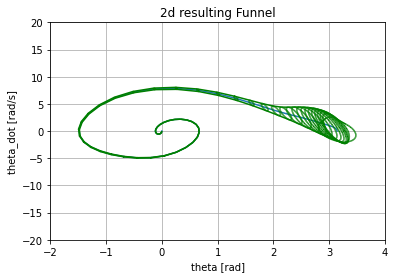

In [23]:
pendulum = PendulumPlant_(mass=mass,
                         length=length,
                         damping=damping,
                         gravity=gravity,
                         coulomb_fric=coulomb_fric,
                         inertia=None,
                         torque_limit=torque_limit)

controller = TVLQRController(data_dict=data_dict, mass=mass, length=length,
                             damping=damping, gravity=gravity,
                             torque_limit=torque_limit)

# Taking the finals values of S and rho from the invariant case, SOS method has been chosen
(rhof, Sf) = SOSequalityConstrained(pendulum,LQRController(mass=mass,
                                                            length=length,
                                                            damping=damping,
                                                            gravity=gravity,
                                                            torque_limit=torque_limit))
controller.set_goal(goal)
S_t = controller.tvlqr.S

# Application of the algorithm for time-variant RoA estimation
(rho, S_t) = TVSOSrhoBiAlternation(pendulum, controller, time, N, rhof)
# nSimulations = 50
# (rho, S_t) = TVprobRhoComputation(pendulum, controller, x0_traj,time, N, nSimulations, rhof)
print("The final rho is: "+str(rho))

# Store the computed funnel
S = S_t.value(time[0]).flatten()
for i in range(1,len(time)):
    S = np.vstack((S,S_t.value(time[i]).flatten()))
saveFunnel(rho, S.T)

# plot the 2d funnel
plotFunnel_fromCsv("log_data/funnel/funnel.csv",x0_traj, time)